In [1]:
!pip install tensorflow

In [2]:
!pip install lightgbm

In [3]:
!pip install graphviz

In [46]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import to_categorical
import random
import numpy as np
from lightgbm import LGBMClassifier, plot_tree
import seaborn as sbn

In [32]:
churned_color = "#E83F6F"
not_churned_color = "#2274A5"

In [5]:
data_url = "https://raw.githubusercontent.com/ray33ee/bank-churn-analysis/main/merged.csv"

In [6]:
df = pd.read_csv(data_url, header=0)

In [7]:
df.head()

,Credit Score,Age,Tenure,Account Balance,No. of products,Has Credit Card,Is Active Member,Estimated Salary,Churned,France,Germany,Spain,Female,Male
0,668,33,3,0.00,2,1,0,181449.97,0,1,0,0,0,1
1,627,33,1,0.00,2,1,1,49503.50,0,1,0,0,0,1
2,678,40,10,0.00,2,1,0,184866.69,0,1,0,0,0,1
3,581,34,2,148882.54,1,1,1,84560.88,0,1,0,0,0,1
4,716,33,5,0.00,2,1,1,15068.83,0,0,0,1,0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185021 entries, 0 to 185020
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Credit Score      185021 non-null  int64  
 1   Age               185021 non-null  int64  
 2   Tenure            185021 non-null  int64  
 3   Account Balance   185021 non-null  float64
 4   No. of products   185021 non-null  int64  
 5   Has Credit Card   185021 non-null  int64  
 6   Is Active Member  185021 non-null  int64  
 7   Estimated Salary  185021 non-null  float64
 8   Churned           185021 non-null  int64  
 9   France            185021 non-null  int64  
 10  Germany           185021 non-null  int64  
 11  Spain             185021 non-null  int64  
 12  Female            185021 non-null  int64  
 13  Male              185021 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 19.8 MB


In [9]:
df.isnull().sum()

Credit Score        0
Age                 0
Tenure              0
Account Balance     0
No. of products     0
Has Credit Card     0
Is Active Member    0
Estimated Salary    0
Churned             0
France              0
Germany             0
Spain               0
Female              0
Male                0
dtype: int64

In [ ]:
df.describe()

In [10]:
# Note: This function modifies the data_frame in place
def detect_outliers(data_frame, column):
    multiplier = 1.5
    q1 = data_frame[column].quantile(0.25)
    q3 = data_frame[column].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + iqr * multiplier
    lower = q1 - iqr * multiplier
    outliers_frames = data_frame.loc[(data_frame[column] < lower) | (data_frame[column] > upper)]
    indices = outliers_frames.index.values
    data_frame.drop(indices, inplace=True)
    print(f"Found and removed {len(indices)} outliers in column '{column}'")

columns_to_check = ["Credit Score", "Age", "Account Balance", "Estimated Salary"]

for c in columns_to_check:
    detect_outliers(df, c)


Found 359 outliers in column 'Credit Score'. Outliers removed.
Found 5780 outliers in column 'Age'. Outliers removed.
Found 0 outliers in column 'Account Balance'. Outliers removed.
Found 0 outliers in column 'Estimated Salary'. Outliers removed.


In [11]:
df.describe()

,Credit Score,Age,Tenure,Account Balance,No. of products,Has Credit Card,Is Active Member,Estimated Salary,Churned,France,Germany,Spain,Female,Male
count,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000
mean,656.253793,37.336166,5.022110,57624.768095,1.553426,0.749080,0.491995,111397.887636,0.206482,0.537533,0.200803,0.209076,0.412635,0.534777
std,81.250997,7.714966,2.813576,63099.757110,0.549433,0.433544,0.499937,51204.855452,0.404782,0.498591,0.400602,0.406650,0.492310,0.498790
min,426.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,72861.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,116537.145000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,711.000000,42.000000,7.000000,121063.900000,2.000000,1.000000,1.000000,154393.965000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,850.000000,59.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# Split the data into two groups, the customers that have churned and ones that have not
churned_group = df.groupby(df["Churned"])
has_churned = churned_group.get_group(1)
not_churned = churned_group.get_group(0)

Percentage churn      : 20.648248566093848
Percentage not churned: 79.35175143390614


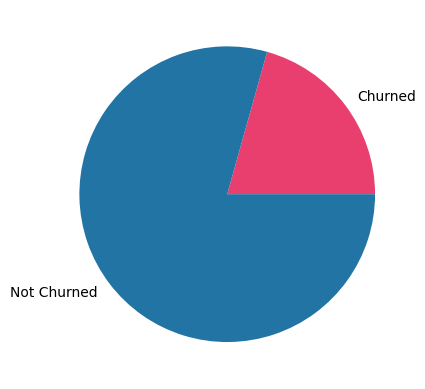

In [34]:
total_rows = len(df.index)
total_has_churned = len(has_churned.index)
churn_percentage = float(total_has_churned) / float(total_rows) * 100.0
print(f"Percentage churn      : {churn_percentage}")
print(f"Percentage not churned: {100.0 - churn_percentage}")
ps = np.array([churn_percentage, 100.0 - churn_percentage])
plt.pie(ps, labels=[f"Churned", "Not Churned"], colors=[churned_color, not_churned_color])
plt.show()

(array([ 2400.,  7988., 19689., 32268., 35028., 24110., 11105.,  4725.,
         2302.,  2331.]),
 array([18. , 22.1, 26.2, 30.3, 34.4, 38.5, 42.6, 46.7, 50.8, 54.9, 59. ]),
 <BarContainer object of 10 artists>)

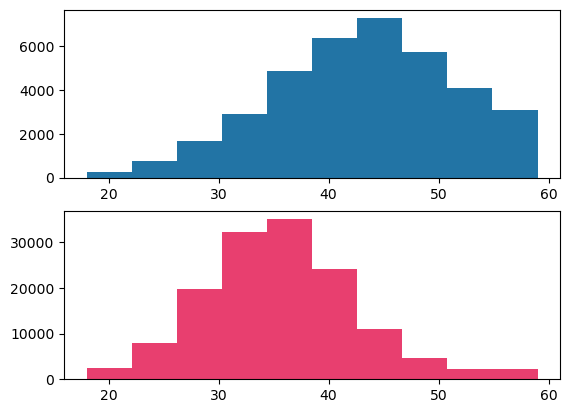

In [36]:
# Todo: color the histograms, label axis, label each plot and title 
fig, a = plt.subplots(2)
a[0].hist(has_churned["Age"], color=not_churned_color)
a[1].hist(not_churned["Age"], color=churned_color)

(array([7.9206e+04, 2.0600e+02, 2.3730e+03, 1.0917e+04, 2.1698e+04,
        1.9711e+04, 6.6390e+03, 1.0910e+03, 9.8000e+01, 7.0000e+00]),
 array([     0.   ,  25089.809,  50179.618,  75269.427, 100359.236,
        125449.045, 150538.854, 175628.663, 200718.472, 225808.281,
        250898.09 ]),
 <BarContainer object of 10 artists>)

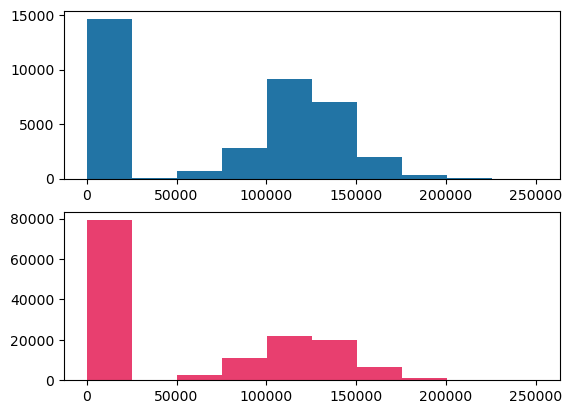

In [37]:
# Todo: color the histograms, label axis, label each plot and title 
fig, a = plt.subplots(2)
a[0].hist(has_churned["Account Balance"], color=not_churned_color)
a[1].hist(not_churned["Account Balance"], color=churned_color)

(array([ 7685.,  6635., 11983., 15294., 17617., 14773., 19088., 18197.,
        19641., 11033.]),
 array([1.1580000e+01, 2.0009670e+04, 4.0007760e+04, 6.0005850e+04,
        8.0003940e+04, 1.0000203e+05, 1.2000012e+05, 1.3999821e+05,
        1.5999630e+05, 1.7999439e+05, 1.9999248e+05]),
 <BarContainer object of 10 artists>)

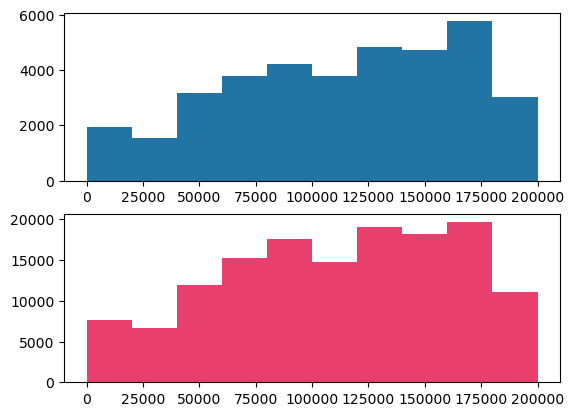

In [38]:
# Todo: color the histograms, label axis, label each plot and title 
fig, a = plt.subplots(2)
a[0].hist(has_churned["Estimated Salary"], color=not_churned_color)
a[1].hist(not_churned["Estimated Salary"], color=churned_color)

(array([64874., 77072.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

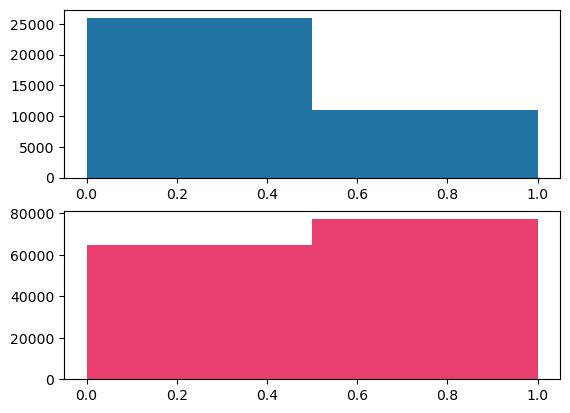

In [39]:
# Todo: color the histograms, label axis, label each plot and title 
fig, a = plt.subplots(2)
a[0].hist(has_churned["Is Active Member"], bins=2, color=not_churned_color)
a[1].hist(not_churned["Is Active Member"], bins = 2, color=churned_color)

(array([ 1497.,  3821.,  9133., 19431., 22197., 27612., 29659., 17040.,
         6358.,  5198.]),
 array([426. , 468.4, 510.8, 553.2, 595.6, 638. , 680.4, 722.8, 765.2,
        807.6, 850. ]),
 <BarContainer object of 10 artists>)

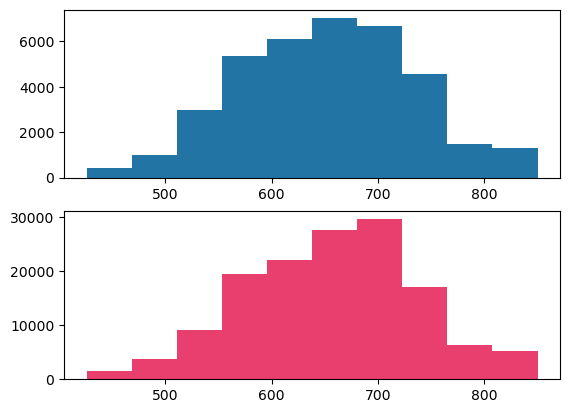

In [40]:
# Todo: color the histograms, label axis, label each plot and title 
fig, a = plt.subplots(2)
a[0].hist(has_churned["Credit Score"], color=not_churned_color)
a[1].hist(not_churned["Credit Score"], color=churned_color)

<Axes: >

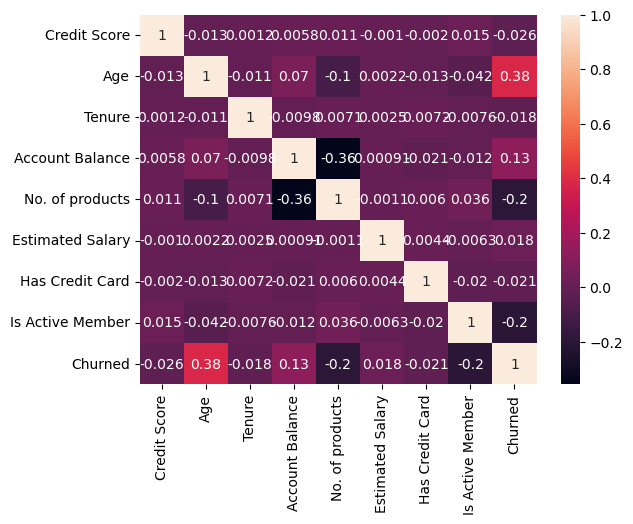

In [21]:
columns = ["Credit Score", "Age", "Tenure", "Account Balance", "No. of products", "Estimated Salary", "Has Credit Card", "Is Active Member", "Churned"]
cm = df[columns].corr()
sbn.heatmap(cm, annot=True)

In [22]:
target = "Churned"
X = df.drop(target, axis=1)
y = df[target]
X = (X - X.mean()) / X.std()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.describe()

,Credit Score,Age,Tenure,Account Balance,No. of products,Has Credit Card,Is Active Member,Estimated Salary,France,Germany,Spain,Female,Male
count,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000
mean,0.000887,-0.001547,-0.001508,-0.000192,-0.000751,-0.000583,-0.001201,0.002255,-0.001902,0.001677,-0.000015,-0.000769,0.000192
std,0.999167,0.999766,0.999480,0.999441,0.999148,1.000335,0.999981,0.999829,1.000142,1.001251,0.999990,0.999864,0.999987
min,-2.833858,-2.506319,-1.784956,-0.913233,-1.007269,-1.727809,-0.984113,-2.175308,-1.078105,-0.501253,-0.514143,-0.838162,-1.072148
25%,-0.729269,-0.691664,-0.718697,-0.913233,-1.007269,-1.727809,-0.984113,-0.751404,-1.078105,-0.501253,-0.514143,-0.838162,-1.072148
50%,0.033799,-0.043573,-0.007858,-0.913233,0.812791,0.578764,-0.984113,0.103406,0.927548,-0.501253,-0.514143,-0.838162,0.932702
75%,0.673791,0.604518,0.702981,1.005373,0.812791,0.578764,1.016138,0.846636,0.927548,-0.501253,-0.514143,1.193080,0.932702
max,2.384539,2.808027,1.769240,3.062980,4.452910,0.578764,1.016138,1.730199,0.927548,1.994991,1.944973,1.193080,0.932702


<class 'pandas.core.frame.DataFrame'>
Index: 184658 entries, 0 to 185020
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   pc1      178882 non-null  float64
 1   pc2      178882 non-null  float64
 2   Churned  178882 non-null  float64
dtypes: float64(3)
memory usage: 5.6 MB


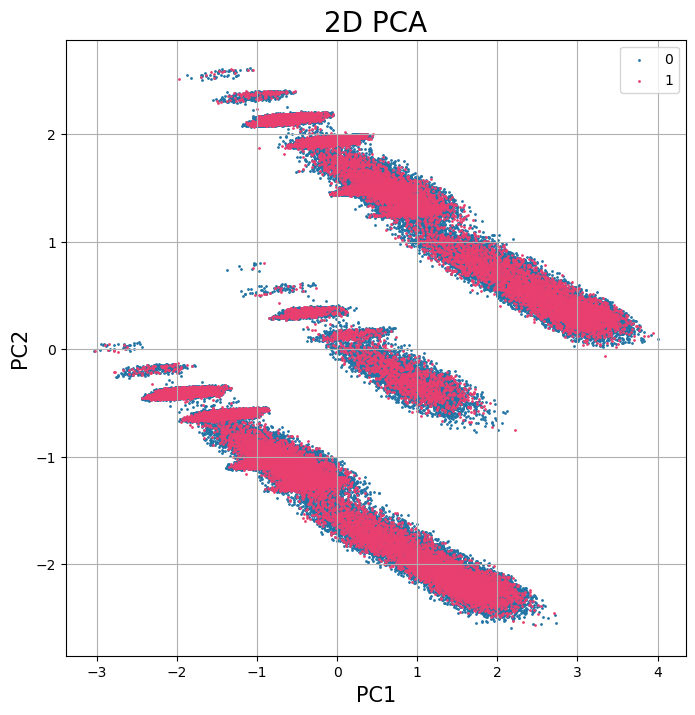

In [41]:
# To do: make sure the legend on the PCA charts say 'Churned' and 'Not churned' rather than '1' and '0'
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf2d = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

finalDf = pd.concat([principalDf2d, df[['Churned']]], axis = 1)

finalDf.info()

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2D PCA', fontsize = 20)

targets = [0, 1]
colors = [not_churned_color, churned_color]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Churned'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 1)
ax.legend(targets)
ax.grid()

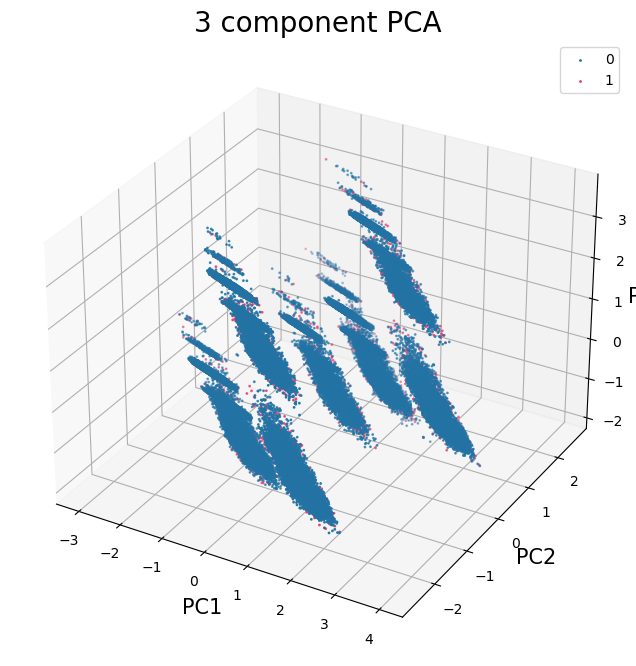

In [44]:
pca = PCA(n_components=3)


principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])

finalDf = pd.concat([principalDf, df[['Churned']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_zlabel('PC3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Churned'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2'], finalDf.loc[indicesToKeep, 'pc3']
               , c = color
               , s = 1)
ax.legend(targets)
ax.grid()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 29570, number of negative: 113535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info] Number of data points in the train set: 143105, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206631 -> initscore=-1.345351
[LightGBM] [Info] Start training from score -1.345351
Model 'LGBM' training and prediction complete
Starting weights & biases seed: 5590860817
Epoch 1/4
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 4s 715us/step - accuracy: 0.7941 - loss: nan
Epoch 2/4
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 3s 766us/step - accuracy: 0.7936 - loss: nan
Epoch 3/4
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 4s 870us/step - accuracy: 0.7922 - loss: nan
Epoch 4/4
4473

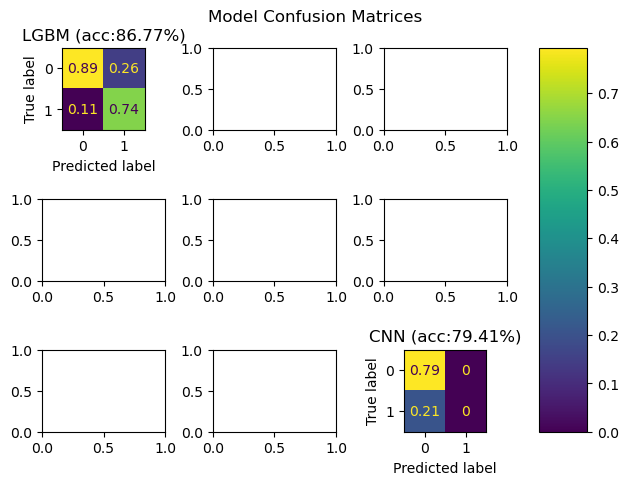

In [74]:


#KNeighborsClassifier

models = [("LGBM", LGBMClassifier()),
         ("LR", LogisticRegression()),
         ("RF", RandomForestClassifier()),
         ("GBC", GradientBoostingClassifier()),
         ("MLP", MLPClassifier()),
         ("ADA", AdaBoostClassifier()),
         ("KNC", KNeighborsClassifier())]


models = [("LGBM", LGBMClassifier()),]


cms = []


fig, axs = plt.subplots(3, 3)

plt.suptitle("Model Confusion Matrices")

for i, (name, model) in enumerate(models):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    im = ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_predict, 
        normalize='pred', 
        ax=axs[i // 3, i % 3], 
        colorbar=False,
        
    )
    _i = im.im_
    axs[i // 3, i % 3].title.set_text(f"{name} (acc:{accuracy*100:.2f}%)")
    #axs[i // 3, i % 3].xlabel("")
    #axs[i // 3, i % 3].ylabel.set_text("")
    
    cms.append((name, cm))
    
    print(f"Model '{name}' training and prediction complete")

# CNN works by outputing two values (corresponding to confidence values for churned and not churned)
# so must be treated slightly differently to the other models:
    
y_ml_train = to_categorical(y_train)
y_ml_test = to_categorical(y_test)

seed = random.randint(0, 2 << 32)
seed = 5590860817
epochs = 4
batch_size = 32

print(f"Starting weights & biases seed: {seed}")

initialiser = keras.initializers.GlorotUniform(seed=seed)

cnn = Sequential()
cnn.add(Input((13,)))
cnn.add(Dense(5, activation="sigmoid", kernel_initializer=initialiser))
cnn.add(Dense(5, activation="relu", kernel_initializer=initialiser))
cnn.add(Dense(5, activation="sigmoid", kernel_initializer=initialiser))
cnn.add(Dense(2, activation="relu", kernel_initializer=initialiser))

cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

cnn.fit(X_train, y_ml_train, epochs=epochs, batch_size=batch_size)

y_predict = np.argmax(cnn.predict(X_test), axis=1)

accuracy = accuracy_score(y_test, y_predict)
im = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_predict, 
    normalize='pred', 
    ax=axs[2, 2], 
    colorbar=False,

)
_i = im.im_
axs[2, 2].title.set_text(f"CNN (acc:{accuracy*100:.2f}%)")
#axs[i // 3, i % 3].xlabel("")
#axs[i // 3, i % 3].ylabel.set_text("")

cms.append(("CNN", cm))

fig.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes((0.85, 0.1, 0.075, 0.8))
plt.colorbar(_i, cax=cax)
    

1119/1119 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step


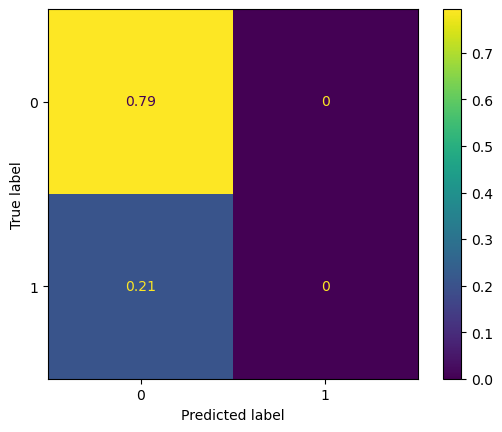

In [84]:
#A terrible CNN model that basically just guesses '0' and manages 79% accuracy because the dataset is 79% '0'.
trivial_model = keras.models.load_model('trivial_model.keras')

y_predict = np.argmax(trivial_model.predict(X_test), axis=1)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, normalize='pred')